In [2]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [3]:
import numpy as np
import pandas as pd

In [4]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [5]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [6]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [7]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [8]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [9]:
# Save references to each table
station = Base.classes.station
measurement = Base.classes.measurement

In [10]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [11]:
engine.execute('SELECT * FROM Station LIMIT 5').fetchall()

[(1, 'USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 (2, 'USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6),
 (3, 'USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0),
 (4, 'USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9),
 (5, 'USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6)]

In [12]:
engine.execute('SELECT * FROM Measurement LIMIT 5').fetchall()

[(1, 'USC00519397', '2010-01-01', 0.08, 65.0),
 (2, 'USC00519397', '2010-01-02', 0.0, 63.0),
 (3, 'USC00519397', '2010-01-03', 0.0, 74.0),
 (4, 'USC00519397', '2010-01-04', 0.0, 76.0),
 (5, 'USC00519397', '2010-01-06', None, 73.0)]

In [13]:
first_row = session.query(measurement).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x12366c550>,
 'tobs': 65.0,
 'date': '2010-01-01',
 'id': 1,
 'prcp': 0.08,
 'station': 'USC00519397'}

In [14]:
first_row = session.query(station).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x12366cdf0>,
 'elevation': 3.0,
 'latitude': 21.2716,
 'longitude': -157.8168,
 'name': 'WAIKIKI 717.2, HI US',
 'station': 'USC00519397',
 'id': 1}

# Exploratory Climate Analysis

In [15]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
last_month = session.query(measurement.date).order_by(measurement.date.desc()).first()
last_month

('2017-08-23')

In [16]:
# Calculate the date 1 year ago from the last data point in the database
last_date = dt.date(2017, 4, 8) - dt.timedelta(days=365)
last_date

datetime.date(2016, 4, 8)

In [17]:
# Perform a query to retrieve the data and precipitation scores
results= session.query(measurement.date, measurement.prcp).\
    filter(measurement.date > last_date).\
    order_by(measurement.date).all()


In [18]:
#Save the query results as a Pandas DataFrame and set the index to the date column
precipitation_df = pd.DataFrame(results, columns=['date', 'precipitation'])
precipitation_df.set_index('date', inplace=True)
precipitation_df.head()

,precipitation
date,
2016-04-09,0.00
2016-04-09,0.66
2016-04-09,0.14
2016-04-09,0.00
2016-04-09,0.27


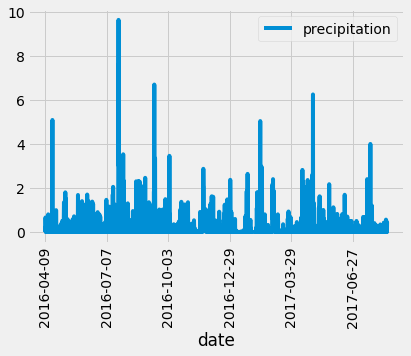

In [19]:
# Sort the dataframe by date
precipitation_df = precipitation_df.sort_values(by='date',ascending=True).dropna()

# Use Pandas Plotting with Matplotlib to plot the data
precipitation_df.plot(rot=90)
plt.show()

In [20]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precipitation_df.describe()

,precipitation
count,2781.000000
mean,0.195638
std,0.523703
min,0.000000
25%,0.000000
50%,0.020000
75%,0.150000
max,9.640000


In [21]:
# Design a query to show how many stations are available in this dataset?

stations = session.query(measurement.station).distinct().count()
stations

9

In [22]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
active_stations = session.query(station.station, func.count(measurement.station).label('actives')).\
                  filter(station.station == measurement.station).\
                  group_by(station.station).\
                  order_by(func.count(measurement.station).desc()).\
                  all()
active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [23]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active stations
active_station = 'USC00519281'
temps = session.query(func.min(measurement.tobs), func.max(measurement.tobs), func.avg(measurement.tobs)).\
    filter(measurement.station == active_station).all()
temps

[(54.0, 85.0, 71.66378066378067)]

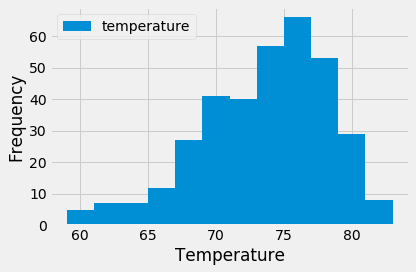

In [24]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temp_observation = session.query(measurement.date, measurement.tobs).filter(measurement.station == active_station).\
    filter(func.strftime("%Y-%m-%d", measurement.date) >= dt.date(2016, 8, 23)).all()
temp_observation_df = pd.DataFrame(temp_observation, columns = ['date', 'temperature'])
fig, ax = plt.subplots()
temp_observation_df.plot.hist(bins = 12, ax = ax)

#labels
ax.set_xlabel('Temperature')
ax.set_ylabel('Frequency')

#save figure
plt.savefig("Images/yearly_plot.png")

#plot
plt.tight_layout()


In [25]:
## Bonus Challenge Assignment

In [27]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(measurement.tobs), func.avg(measurement.tobs), func.max(measurement.tobs)).\
        filter(measurement.date >= start_date).filter(measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [39]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
trip = calc_temps('2017-07-01','2017-07-14')
trip

[(69.0, 78.11627906976744, 87.0)]

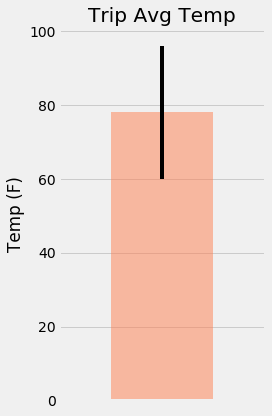

In [33]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
trip_temp_df = pd.DataFrame(trip, columns=['tmin', 'tavg', 'tmax'])
trip_temp_df.plot.bar(y='tavg', yerr=(trip_temp_df['tmax'] - trip_temp_df['tmin']), title='Trip Avg Temp', color='coral', alpha=0.5, figsize=(4,6))
plt.xticks(np.arange(1, 1.0))
plt.ylabel("Temp (F)")
plt.tight_layout()
plt.gca().legend_.remove()
plt.savefig("Images/TripAvgTemp.png")
plt.show()

In [ ]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [37]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(measurement.tobs), func.avg(measurement.tobs), func.max(measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [43]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`
start_date = '2017-07-01'
end_date ='2017-07-14'
# Set the start and end date of the trip
dates = session.query(measurement.date).filter(measurement.date >= start_date).filter(measurement.date <= end_date).group_by(measurement.date).all()
# Use the start and end date to create a range of dates
trip_dates = [x[0] for x in dates]
# Stip off the year and save a list of %m-%d strings
trip_dates_stripped= [x[5:] for x in trip_dates]

# Loop through the list of %m-%d strings and calculate the normals for each date
daily_normals = [session.query(func.min(measurement.tobs),
                       func.avg(measurement.tobs),
                       func.max(measurement.tobs)).filter(func.strftime("%m-%d", measurement.date) >= start_month_day).filter(func.strftime("%m-%d", measurement.date) <= end_month_day).group_by(func.strftime("%m-%d", measurement.date)).all()]

daily_normals = daily_normals[0]
print("Aggregate Daily Normals for 07-01 to 07-14")
daily_normals


Aggregate Daily Normals for 07-01 to 07-14


[(67.0, 74.77777777777777, 81.0),
 (68.0, 75.40384615384616, 82.0),
 (68.0, 75.32075471698113, 87.0),
 (70.0, 76.57142857142857, 81.0),
 (66.0, 75.0, 81.0),
 (69.0, 75.0, 81.0),
 (69.0, 74.91071428571429, 82.0),
 (69.0, 76.08333333333333, 83.0),
 (68.0, 76.19298245614036, 83.0),
 (68.0, 75.62068965517241, 82.0),
 (70.0, 75.78947368421052, 81.0),
 (67.0, 75.96491228070175, 82.0),
 (69.0, 76.1896551724138, 81.0),
 (61.0, 76.2280701754386, 82.0)]

In [45]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
daily_normals_df= pd.DataFrame(daily_normals,columns=['tmin', 'tavg', 'tmax'])
daily_normals_df['date']= trip_dates
daily_normals_df['date'] = pd.to_datetime(daily_normals_df['date'], format='%Y-%m-%d')
daily_normals_df.set_index('date',inplace=True)
daily_normals_df

,tmin,tavg,tmax
date,,,
2017-07-01,67.0,74.777778,81.0
2017-07-02,68.0,75.403846,82.0
2017-07-03,68.0,75.320755,87.0
2017-07-04,70.0,76.571429,81.0
2017-07-05,66.0,75.000000,81.0
2017-07-06,69.0,75.000000,81.0
2017-07-07,69.0,74.910714,82.0
2017-07-08,69.0,76.083333,83.0
2017-07-09,68.0,76.192982,83.0


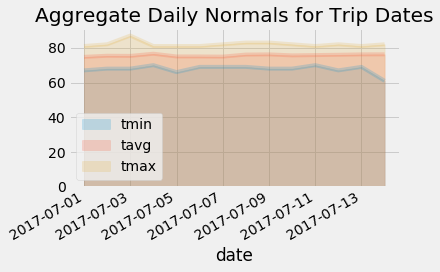

In [46]:
# Plot the daily normals as an area plot with `stacked=False`
daily_normals_df.plot(kind='area', alpha=.2, stacked=False, x_compat=True, title="Aggregate Daily Normals for Trip Dates")
plt.tight_layout()
plt.savefig("Images/DailyNormals.png")
plt.show()